## Analyze degenerate barcodes
20221006 - Meant to be run after processing of unmapped reads (generated by CellRanger) using Picard / Samtools

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pysam
import scipy.stats

from Bio import SeqIO

np.random.seed(5)

In [2]:
hashes = {}
import csv
with open('barcodes.csv') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    #first column forward, second column reverse complement
    for row in csvreader:
        if row[0].startswith("#"): continue
        hashes[row[0]] = row[2]

In [3]:
hashes

{'TGTCTAGT': 'shRenilla-1',
 'CTGAATCT': 'Myc (63)',
 'TTAATTAG': 'Onecut2 (76)',
 'CGGGAATG': 'Fosl2 (60)',
 'GCCTACGT': 'Fhl2 (61)',
 'GCCAATCG': 'Itga2 (1811)',
 'CGTTTCCT': 'Cldn4 (1999)',
 'ACACGTGA': 'Lif (2114)',
 'CAGTGCAT': 'Nfkb1 (2118)',
 'CGTTAGGG': 'Yap1 (65)',
 'CGTTCAAG': 'Nfkb2 (71)',
 'GGTAGGGA': 'Fosl1 (2115)',
 'ACAGAGCC': 'Relb (73) ',
 'GTACTTGC': 'patch4.4-1',
 'CCATTACT': 'patch4.4-2',
 'CATAGTCA': 'shRenilla-2',
 'TCTGGGGC': 'Atf4 (67)'}

In [4]:
#hashes = {"TGTCTAGT": "shRenilla", "CTGAATCT": "shMyc(63)", "TTAATTAG": "shOnecut2(76)"}
hashmatch = re.compile('GT[ATCG]{5}AA[ATCG]{5}TT[ATCG]{5}AA') #forward
#hashmatch = re.compile('TT[ATCG]{5}AA[ATCG]{5}TT[ATCG]{5}AC') #reverse complement

In [5]:
def hammingDistance(a, b):
    return sum(str1 != str2 for str1, str2 in zip(a, b))

In [6]:
#Changed this to actual experimental whitelist
import pickle
whitelist = set()
#open whitelist
with open('../write/cellwhitelist4.pickle', 'rb') as f:
    whitelist = pickle.load(f)

In [7]:
print(len(whitelist))

7072


In [8]:
afile = pysam.AlignmentFile("./final.bam")
hashcount = {}
hashset = {}
cellhash = {}
taghash = {}
readcount = {}
barcodehash = {} # barcodes listing shRNAID
barcodebycellUMI = {} # barcode listing cellUMI
doublecounts = 0
cellbyUMI = {}
inwhitelist = set()
inwhitelistcount = 0
outwhitelist = set()
outwhitelistcount = 0
for seq_record in afile.fetch(until_eof=True):
    cellUMI = None  # here this is the CellRanger cell UMI
    UMI = None
    if not seq_record.has_tag("CB") or not seq_record.has_tag("UB"): continue
    cellUMI = seq_record.get_tag("CB")
    if cellUMI not in whitelist: 
        outwhitelistcount +=1
        if cellUMI not in outwhitelist: outwhitelist.add(cellUMI)
        continue
    else:
        inwhitelistcount += 1
        if cellUMI not in inwhitelist: inwhitelist.add(cellUMI)
    UMI = seq_record.get_tag("UB") # umi barcode
    
    m = hashmatch.search(seq_record.query_sequence)
    if m == None or (m.end() + 8) > len(seq_record.query_sequence):
        #print("Error, match not found")
        continue
    shRNAID = seq_record.query_sequence[m.end():m.end()+8]
    barcode = seq_record.query_sequence[m.end()-21:m.end()]
    sbID = (shRNAID,barcode)
    if shRNAID not in hashes: continue
    if cellUMI not in cellbyUMI:
        cellbyUMI[cellUMI] = {}
    if UMI not in cellbyUMI[cellUMI]:
        cellbyUMI[cellUMI][UMI] = {sbID: 1}
        continue
    if sbID in cellbyUMI[cellUMI][UMI]:
        cellbyUMI[cellUMI][UMI][sbID] += 1
    else:
        hamming = False
        for x in cellbyUMI[cellUMI][UMI]:
            if hammingDistance(sbID[1],x[1]) <= 2:
                cellbyUMI[cellUMI][UMI][x] += 1
                hamming = True
                break
        if hamming: continue
        cellbyUMI[cellUMI][UMI][sbID] = 1


In [9]:
totalUMI = 0
for cellUMI in cellbyUMI:
    totalUMI += len(cellbyUMI[cellUMI])
print(totalUMI)

3566185


In [10]:
print("In Whitelist UMI: %d\nOut Whitelist UMI: %d" % (len(inwhitelist), len(outwhitelist)))
print("In Whitelist Reads: %d\nOut Whitelist Reads: %d" % (inwhitelistcount, outwhitelistcount))

In Whitelist UMI: 7071
Out Whitelist UMI: 400168
In Whitelist Reads: 272150025
Out Whitelist Reads: 29317606


In [11]:
import pickle
with open('cellbyUMI.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(cellbyUMI, f, pickle.HIGHEST_PROTOCOL)

## IGNORE THIS

## END IGNORE

In [12]:
from IPython.core.debugger import set_trace

In [13]:
# first pass generate histogram of counts
histogram_of_counts = []
for UMI in cellbyUMI:
    for y in cellbyUMI[UMI]:
        histogram_of_counts.extend(cellbyUMI[UMI][y].values())

By UMI/Cell


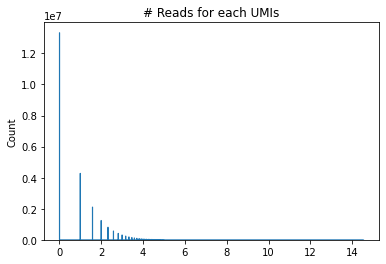

In [14]:
# should only be shRNA per UMI
print("By UMI/Cell")
_ = plt.hist(np.log2(histogram_of_counts), bins='auto', histtype='step')
plt.ylabel("Count")
plt.title("# Reads for each UMIs")
#cutoff = _[1][1]
#plt.axvline(x=cutoff)
plt.show()

In [15]:
count = 0
for x in range(0,len(_[1])):
    if x == 0: continue
    if round(_[1][x]) >= 1:
        count = x
        break

In [16]:
count

46

By UMI/Cell


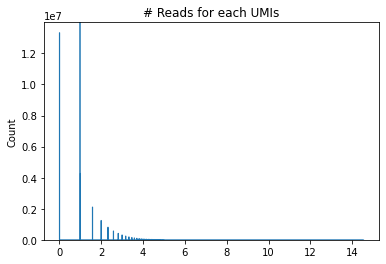

In [17]:
# should only be shRNA per UMI
print("By UMI/Cell")
_ = plt.hist(np.log2(histogram_of_counts), bins='auto', histtype='step')
plt.ylabel("Count")
plt.title("# Reads for each UMIs")
cutoff = round(_[1][count])
plt.axvline(x=cutoff)
plt.show()

In [18]:
cutoff = 2**(round(cutoff))
print(cutoff)

2


In [19]:
len(cellbyUMI)

7071

In [20]:
# Cleanup, prune any reads that don't pass the cutoff
for UMI in cellbyUMI:
    for y in cellbyUMI[UMI]:
        toRemove = []
        for z in cellbyUMI[UMI][y]:
            if cellbyUMI[UMI][y][z] <= cutoff: toRemove.append(z)
        for z in toRemove:
            del cellbyUMI[UMI][y][z]
    toRemove = []
    for y in cellbyUMI[UMI]:
        if len(cellbyUMI[UMI][y]) == 0: toRemove.append(y)
    for y in toRemove:
        del cellbyUMI[UMI][y]
toRemove = []
for UMI in cellbyUMI:
    if len(cellbyUMI[UMI]) == 0: toRemove.append(UMI)
for UMI in toRemove:
    del cellbyUMI[UMI]

In [21]:
len(cellbyUMI)

6677

## second pass onwards

## end pass

In [22]:
## counting total UMIs from dominant shRNA
histogram_of_UMIs = []
assignedCellshRNA = {}
assignedCellbarcode = {}
poorUMI = []
poorUMI2 = []
count = []
threshold = cutoff

for x in cellbyUMI:
    ncellbyUMI = {}
    for y in cellbyUMI[x]:
        UMIpairs = [(cellbyUMI[x][y][z],z) for z in cellbyUMI[x][y]] # stored as (count, (shRNAID,barcode))
        UMIpairs.sort(reverse=True)
        newUMI = []
        while len(UMIpairs) != 0:
            shRNAIDbarcodepair = UMIpairs.pop(0) #
            toDelete = []
            for z in range(0, len(UMIpairs)):
                if shRNAIDbarcodepair[1][0] != UMIpairs[z][1][0]: continue
                if hammingDistance(shRNAIDbarcodepair[1][1],UMIpairs[z][1][1]) <= 2:
                    toDelete.append(z)
                    shRNAIDbarcodepair = (shRNAIDbarcodepair[0]+UMIpairs[z][0],shRNAIDbarcodepair[1])
            newUMI.append(shRNAIDbarcodepair)
            for z in sorted(toDelete, reverse = True):
                del UMIpairs[z]

        if len(newUMI) == 1:
        # uncomment here if we don't want to ignore single counts
            if newUMI[0][0] < threshold: 
                print("Not past threshold: %s" % str(newUMI))
            else:
                ncellbyUMI[y] = newUMI[0][1]
            continue

        # Shouldn't happen anymore with the cleaned up version
        newUMI.sort(reverse=True)
        if newUMI[0][0] < threshold: continue
            
        totalUMI = sum([z[0] for z in newUMI])
        if scipy.stats.binom_test(newUMI[0][0], totalUMI, 1/len(newUMI), alternative='greater') <= 0.05:
            ncellbyUMI[y] = newUMI[0][1]       
#        else:
#            print(newUMI)
        #### end
        
    UMIpairs = {}

    if len(ncellbyUMI) == 0: 
        print("is zero")
        continue            
            
#    if len(ncellbyUMI) == 1:
#        continue
        # uncomment here if we don't want to ignore UMIs assigned by single counts
        #assignedCellshRNA[x] = list(ncellbyUMI.values())[0][0]
        #assignedCellbarcode[x] = list(ncellbyUMI.values())[0][1]
        #count.append(1)

        #adding single UMIs to poorUMI list instead of assigning label
#        poorUMI.append([(1,ncellbyUMI)])
#        poorUMI2.append(x)
#        continue

    for y in ncellbyUMI:   #ncellbyUMI[UMI] = (shRNAID, barcode)
        if ncellbyUMI[y] in UMIpairs:
            UMIpairs[ncellbyUMI[y]] += 1
        else:
            hamming=False
            for z in UMIpairs:  #instead of assigning this randomly I could order it by number of highest read counts
                if z[0] != ncellbyUMI[y][0]: continue
                if hammingDistance(ncellbyUMI[y][1], z[1]) <= 2:
                    UMIpairs[z] += 1
                    hamming=True
                    break
            if hamming: continue
            UMIpairs[ncellbyUMI[y]] = 1
    histogram_of_UMIs.extend(UMIpairs.values())
    continue
    
    
    
#    if len(UMIpairs) == 0: 
#        print("UMIPairs")
#        print(ncellbyUMI)
#        print(cellbyUMI[x])
#        print("error this shoudl not happen")
#        continue

    if len(UMIpairs) == 1:
        if list(UMIpairs.values())[0] < cutoff2: 
            print("Didn't pass cutoff2: %d, %s" % (cutoff2, str(UMIpairs)))
            continue        
        assignedCellshRNA[x] = list(UMIpairs.keys())[0][0]
        assignedCellbarcode[x] = list(UMIpairs.keys())[0][1]
        count.append(list(UMIpairs.values())[0])
        continue        
    
    newUMI = [(UMIpairs[y], y) for y in UMIpairs]  # UMIpairs[(shRNAID, barcode)] = count
    newUMI.sort(reverse=True)

    if newUMI[0][0] < cutoff2: 
        print("Not past UMI threshold: %s" % str(newUMI))
        continue
    totalUMI = sum([y[0] for y in newUMI])
    count.extend([z[0] for z in newUMI if z[0] >= 5])

#    set_trace()
    if len(newUMI) == 2: # newUMI = [(count, (shRNAID, barcode)), ...]
        if newUMI[0][0] - newUMI[1][0] >= 3 and newUMI[1][0] <= 3:
            assignedCellshRNA[x] = newUMI[0][1][0]
            assignedCellbarcode[x] = newUMI[0][1][1]
        continue
    if scipy.stats.binom_test(newUMI[0][0], totalUMI, 1/len(newUMI), alternative='greater') <= 0.10:
        assignedCellshRNA[x] = newUMI[0][1][0]
        assignedCellbarcode[x] = newUMI[0][1][1]
        continue
    else:
        set_trace()
    poorUMI.append(newUMI)
    poorUMI2.append(x)

is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero


By UMI/Cell


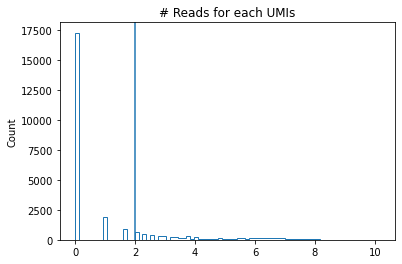

In [23]:
# should only be shRNA per UMI
print("By UMI/Cell")
_ = plt.hist(np.log2(histogram_of_UMIs), bins='auto', histtype='step')
#_ = plt.hist(histogram_of_UMIs, bins='auto', histtype='step')

plt.ylabel("Count")
plt.title("# Reads for each UMIs")
cutoff2 = 2
plt.axvline(x=cutoff2)
plt.show()

In [24]:
cutoff2 = 2**cutoff2
print(cutoff2)

4


In [25]:
## counting total UMIs from dominant shRNA
assignedCellshRNA = {}
assignedCellbarcode = {}
poorUMI = []
poorUMI2 = []
count = []
threshold = cutoff

for x in cellbyUMI:
    ncellbyUMI = {}
    for y in cellbyUMI[x]:
        UMIpairs = [(cellbyUMI[x][y][z],z) for z in cellbyUMI[x][y]] # stored as (count, (shRNAID,barcode))
        UMIpairs.sort(reverse=True)
        newUMI = []
        while len(UMIpairs) != 0:
            shRNAIDbarcodepair = UMIpairs.pop(0) #
            toDelete = []
            for z in range(0, len(UMIpairs)):
                if shRNAIDbarcodepair[1][0] != UMIpairs[z][1][0]: continue
                if hammingDistance(shRNAIDbarcodepair[1][1],UMIpairs[z][1][1]) <= 2:
                    toDelete.append(z)
                    shRNAIDbarcodepair = (shRNAIDbarcodepair[0]+UMIpairs[z][0],shRNAIDbarcodepair[1])
            newUMI.append(shRNAIDbarcodepair)
            for z in sorted(toDelete, reverse = True):
                del UMIpairs[z]

        if len(newUMI) == 1:
        # uncomment here if we don't want to ignore single counts
            if newUMI[0][0] >= threshold: ncellbyUMI[y] = newUMI[0][1]
            continue

        # Shouldn't happen anymore with the cleaned up version
        newUMI.sort(reverse=True)
        if newUMI[0][0] < threshold: continue
    
        totalUMI = sum([z[0] for z in newUMI])
        if scipy.stats.binom_test(newUMI[0][0], totalUMI, 1/len(newUMI), alternative='greater') <= 0.05:
            ncellbyUMI[y] = newUMI[0][1]
#        else:
#            print(newUMI)
        
        #### end
        
    UMIpairs = {}

    if len(ncellbyUMI) == 0: 
        print("is zero")
        poorUMI2.append(x)
        continue            
        
#    if len(ncellbyUMI) == 1:
#        continue
        # uncomment here if we don't want to ignore UMIs assigned by single counts
        #assignedCellshRNA[x] = list(ncellbyUMI.values())[0][0]
        #assignedCellbarcode[x] = list(ncellbyUMI.values())[0][1]
        #count.append(1)

        #adding single UMIs to poorUMI list instead of assigning label
#        poorUMI.append([(1,ncellbyUMI)])
#        poorUMI2.append(x)
#        continue

    for y in ncellbyUMI:   #ncellbyUMI[UMI] = (shRNAID, barcode)
        if ncellbyUMI[y] in UMIpairs:
            UMIpairs[ncellbyUMI[y]] += 1
        else:
            hamming=False
            for z in UMIpairs:  #instead of assigning this randomly I could order it by number of highest read counts
                if z[0] != ncellbyUMI[y][0]: continue
                if hammingDistance(ncellbyUMI[y][1], z[1]) <= 2:
                    UMIpairs[z] += 1
                    hamming=True
                    break
            if hamming: continue
            UMIpairs[ncellbyUMI[y]] = 1
    
#    if len(UMIpairs) == 0: 
#        print("UMIPairs")
#        print(ncellbyUMI)
#        print(cellbyUMI[x])
#        print("error this shoudl not happen")
#        continue

    if len(UMIpairs) == 1:
        if list(UMIpairs.values())[0] < cutoff2: 
            #print("Not past UMI Threshold: %s" % str(UMIpairs))
            poorUMI.append(UMIpairs)
            poorUMI2.append(x)
            continue
        assignedCellshRNA[x] = list(UMIpairs.keys())[0][0]
        assignedCellbarcode[x] = list(UMIpairs.keys())[0][1]
        count.append(list(UMIpairs.values())[0])
        continue        
    
    newUMI = [(UMIpairs[y], y) for y in UMIpairs]  # UMIpairs[(shRNAID, barcode)] = count
    newUMI.sort(reverse=True)
    if newUMI[0][0] < cutoff2: 
        #print("Not past second cutoff: %s" % str(UMIpairs))
        poorUMI.append(newUMI)
        poorUMI2.append(x)
        continue

    totalUMI = sum([y[0] for y in newUMI])
    count.extend([z[0] for z in newUMI])

    if scipy.stats.binom_test(newUMI[0][0], totalUMI, 1/len(newUMI), alternative='greater') <= 0.15:
        assignedCellshRNA[x] = newUMI[0][1][0]
        assignedCellbarcode[x] = newUMI[0][1][1]
        continue

    poorUMI.append(newUMI)
    poorUMI2.append(x)

is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero
is zero


In [26]:
import statistics
sum(count)/len(count), min(count), max(count), statistics.median(count)

(15.31190917725813, 1, 1144, 1)

By UMI/Cell


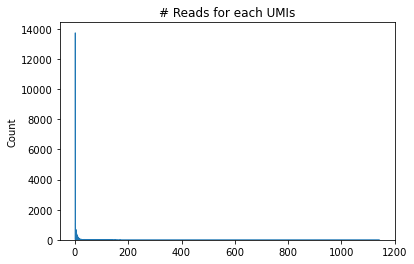

In [27]:
# should only be shRNA per UMI
print("By UMI/Cell")
_ = plt.hist(count, bins='auto', histtype='step')
plt.ylabel("Count")
plt.title("# Reads for each UMIs")
plt.show()

By UMI/Cell


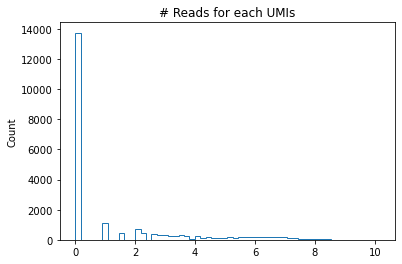

In [28]:
# should only be shRNA per UMI
print("By UMI/Cell")
_ = plt.hist(np.log2(count), bins='auto', histtype='step')
plt.ylabel("Count")
plt.title("# Reads for each UMIs")
plt.show()

In [29]:
len(assignedCellshRNA)

4373

In [30]:
len(whitelist)

7072

In [31]:
#count.sort()
#count

In [32]:
len(poorUMI)

2277

In [33]:
poorUMI

[[(8, ('CATAGTCA', 'AAAAAAAAAAAATTATAAGAA')),
  (4, ('ACAGAGCC', 'AAAGAAATTTAATTTCTCTAA'))],
 [(5, ('CGTTCAAG', 'TTTTTAAAAATGTTGGTATAA')),
  (4, ('ACAGAGCC', 'AAAGAAATTTAATTTCTCTAA')),
  (1, ('TGTCTAGT', 'GGGGGAAGCGGTTTGGAGGAA'))],
 [(4, ('GGTAGGGA', 'TAGTGAATCGTCTTTTCATAA')),
  (2, ('ACAGAGCC', 'AAAGAAATTTAATTTCTCTAA')),
  (1, ('CGGGAATG', 'CCCCCAAACCCCTTCACCCAA'))],
 [(6, ('ACAGAGCC', 'TGGTTAAATTTCTTTATTGAA')),
  (5, ('ACAGAGCC', 'AAAGAAATTTAATTTCTCTAA'))],
 [(4, ('CCATTACT', 'CCCCCAATCCCCTTCCGTCAA')),
  (3, ('ACAGAGCC', 'AAAGAAATTTAATTTCTCTAA')),
  (1, ('GGTAGGGA', 'AATGGAAATACTTTATGAAAA'))],
 [(4, ('ACACGTGA', 'GAAGGAATGGGGTTGTTGGAA')),
  (1, ('ACAGAGCC', 'AAAGAAATTTAATTTCTCTAA'))],
 [(3, ('CTGAATCT', 'ATAAAAAACCCATTAATTCAA')),
  (1, ('GGTAGGGA', 'TTCACAAGAGATTTTATTCAA')),
  (1, ('CGGGAATG', 'CCCGCAACCCTCTTCCCCCAA')),
  (1, ('ACAGAGCC', 'AAAGAAATATAATTTCTCTAA'))],
 [(5, ('ACAGAGCC', 'AAAGAAATTTAATTTCTCTAA')),
  (5, ('ACACGTGA', 'TTTTAAATTTTTTTGTGTTAA')),
  (1, ('GTACTTGC', 'TCTCGAA

In [34]:
#calculate average hammandDistance
hdist = []
for x in poorUMI:
    if len(x) == 1:
#        hdist.append(0)
        continue
    y = [(z[1][0], z[1][1]) for z in x]
    pUMI = {}
    for z in y:
        if z[0] not in pUMI:
            pUMI[z[0]] = [z[1]]
        else:
            pUMI[z[0]].append(z[1])
    for y in pUMI:
        if len(pUMI[y]) < 2:
            continue
        for i in range(0, len(pUMI[y])):
            for j in range(i+1, len(pUMI[y])):
                hdist.append(hammingDistance(pUMI[y][i], pUMI[y][j]))
                if hammingDistance(pUMI[y][i], pUMI[y][j]) == 2:
                    print(pUMI[y])
                    print(pUMI[y][i], pUMI[y][j])

    

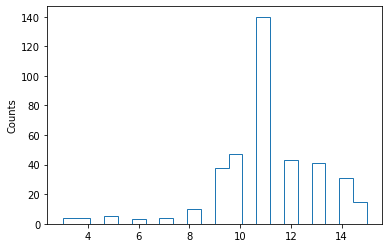

In [35]:
_ = plt.hist(hdist, bins='auto', histtype='step')

plt.ylabel("Counts")
plt.show()

#assign shRNA to barcodes with same shRNA virus
for x in range(len(poorUMI)):
    y = [z[1][0] for z in poorUMI[x]]
    if len(set(y)) == 1:
        assignedCellshRNA[poorUMI2[x]] = y[0]
        assignedCellbarcode[poorUMI2[x]] = "NA"

In [36]:
validshRNANameHash = {}
for x in assignedCellshRNA:
    validshRNANameHash[x] = hashes[assignedCellshRNA[x]]

In [37]:
len(assignedCellbarcode)

4373

In [38]:
import pandas as pd
pUMI = {}
for x in poorUMI2:
    pUMI[x] = 1
cellhashobj = pd.DataFrame.from_dict(pUMI, orient='index')
cellhashobj.rename(columns={0: "pUMI"}, inplace=True)
cellhashobj.to_pickle('pUMIcDNA.pickle')

In [39]:
import pandas as pd
  
cellhashobj = pd.DataFrame.from_dict(validshRNANameHash, orient='index')
cellhashobj.rename(columns={0: "shRNA"}, inplace=True)
cellhashobj.to_pickle('shRNAcDNA.pickle')

cellhashobj = pd.DataFrame.from_dict(assignedCellbarcode, orient='index')
cellhashobj.rename(columns={0: "barcode"}, inplace=True)
cellhashobj.to_pickle('barcodecDNA.pickle')

## END CODE HERE FOR NOW